# Progetto Big Data
## Analisi di algoritmi di clustering
### Edoardo Signoretto
### VR496214

Algoritmo trattati:
- K - Means
- DBSCAN
- Gaussian Mixture Models (GMM)

In [7]:
import sys
print(sys.version)

3.9.6 (default, Nov 11 2024, 03:15:38) 
[Clang 16.0.0 (clang-1600.0.26.6)]


In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
print(f"\nSpark Version: {spark.version}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/17 10:12:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



Spark Version: 3.5.1


# Dataset
- **Titolo**: Individual Household Electric Power Consumption
- **Link**: https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

In [9]:
import pandas as pd
data = pd.read_csv('household_power_consumption.txt', delimiter=';', low_memory=False) # false = leggo intero file in un'unica operazione

In [10]:
print(data.columns)

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')


In [11]:
num_rows = data.shape[0]
print("Numero di righe:", num_rows)

Numero di righe: 2075259


## Pulizia dei dati

In [12]:
data.replace('?', pd.NA, inplace=True)
data.dropna(inplace=True)

for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']:
    data[col] = pd.to_numeric(data[col], errors='coerce') #trasformo le colonne in valori interi, altrimenti NaN

data.reset_index(drop=True, inplace=True)
num_rows = data.shape[0]
print("Numero di righe dopo la pulizia dei dati:", num_rows)

Numero di righe dopo la pulizia dei dati: 2049280


In [13]:
# SELEZIONE DELLE COLONNE DI INTERESSE
consumption_data = data[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']]

## Normalizzazione dei dati

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(consumption_data)

In [15]:
scaled_data

array([[ 2.95507706,  2.61072061, -1.85181608,  3.09878851],
       [ 4.03708463,  2.77040557, -2.2252745 ,  4.13379998],
       [ 4.05032598,  3.32043153, -2.33021323,  4.13379998],
       ...,
       [-0.14529076, -1.09751893, -0.31477235, -0.18624791],
       [-0.149074  , -1.09751893, -0.35180955, -0.18624791],
       [-0.15096563, -1.09751893, -0.39810605, -0.18624791]])

# K-Means
## Metodo del gomito

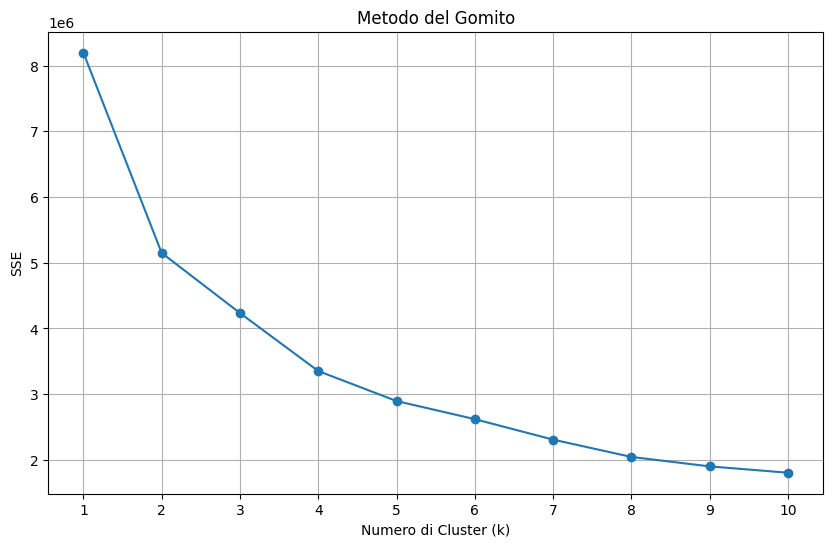

In [16]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42) # KMEANS DELLA LIBRERIA
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o', linestyle='-')
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('SSE')
plt.title('Metodo del Gomito')

plt.xticks(k_range)
plt.grid(True)
plt.show()

## Implementazione KMEANS da libreria

In [17]:
import time 
from memory_profiler import memory_usage
from sklearn.cluster import KMeans

def kmeans_with_profiling(scaled_data, n_clusters=3, random_state=42):
    start_time = time.time() 
    mem_before = memory_usage()[0] 

    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(scaled_data) #ASSEGNA I CLUSTER A CIASCUN DATO

    mem_after = memory_usage()[0]
    mem_used = mem_after - mem_before
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Tempo di esecuzione: {elapsed_time:.4f} secondi")
    print(f"Memoria utilizzata: {mem_used:.4f} MiB")

    data['Cluster'] = clusters    
    return clusters, elapsed_time, mem_used

In [18]:
clusters, elapsed_time, mem_used = kmeans_with_profiling(scaled_data)
cluster_counts = data['Cluster'].value_counts() # AGGIUNGO COLONNA CON CLUSTER AL DATASET
print(cluster_counts)

Tempo di esecuzione: 0.6884 secondi
Memoria utilizzata: 0.0312 MiB
Cluster
2    1217913
1     519539
0     311828
Name: count, dtype: int64


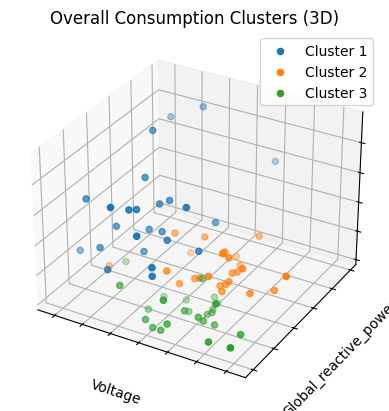

In [19]:
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.pyplot as plt

k = 3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for cluster in range(k):
    cluster_data = data[data["Cluster"] == cluster].sample(n=25)
    ax.scatter(cluster_data["Voltage"], cluster_data["Global_reactive_power"], cluster_data["Global_intensity"], label=f"Cluster {cluster+1}")

ax.tick_params(axis='x', labelbottom=False)
ax.tick_params(axis='y', labelleft=False)
ax.tick_params(axis='z', labelleft=False)

ax.set_xlabel("Voltage")
ax.set_ylabel("Global_reactive_power")
ax.set_zlabel("Global_intensity")
plt.title("Overall Consumption Clusters (3D)")
plt.legend()

plt.show()

## Implementazione KMEANS

In [20]:
import pandas as pd
import numpy as np

data = pd.read_csv('household_power_consumption.txt', delimiter=';', low_memory=False)

In [21]:
data.replace('?', np.nan, inplace=True)

for col in data.columns[2:]:
    data[col] = pd.to_numeric(data[col], errors='coerce') #trasformo le colonne in valori interi, altrimenti NaN
data.dropna(inplace=True)

features = data[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']].values
features_mean = np.mean(features, axis=0)
features_std = np.std(features, axis=0)
features_scaled = (features - features_mean) / features_std

25/01/17 10:13:16 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [22]:
import numpy as np

def euclidean_distance(a, b):
    return np.linalg.norm(a - b) #calcola distanza euclidea

def initialize_centroids(X, k):
    """
    Inizializzo casualmente i centroidi scegliendo `k` punti dal dataset `X`
    - X: matrice dei dati
    - k: numero di cluster (centroidi) da inizializzare.
    """
    np.random.seed(42)
    random_indices = np.random.permutation(X.shape[0])
    centroids = X[random_indices[:k]] #primi `k` punti casuali come centroidi
    return centroids

def assign_clusters(X, centroids):
    """
    Assegno ogni punto al cluster più vicino.
    - X: matrice dei dati
    - centroids: matrice dei centroidi attuali.
    """
    clusters = []
    for x in X:
        distances = [euclidean_distance(x, centroid) for centroid in centroids]
        closest_centroid = np.argmin(distances) # restituisce l'indice della posizione del valore minimo
        clusters.append(closest_centroid) 
    return np.array(clusters)

def update_centroids(X, clusters, k):
    """
    Calcolo i nuovi centroidi come la media dei punti assegnati a ciascun cluster
    - X: matrice dei dati.
    - clusters: array degli indici dei cluster assegnati a ciascun punto
    - k: numero di cluster
    """
    new_centroids = np.zeros((k, X.shape[1])) # array di zeri
    for i in range(k):
        points_in_cluster = X[clusters == i]
        if len(points_in_cluster) > 0:
            new_centroids[i] = np.mean(points_in_cluster, axis=0)
    return new_centroids

def kmeans_function(X, k, max_iters=100):
    centroids = initialize_centroids(X, k)
    
    for _ in range(max_iters):
        clusters = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, clusters, k)
        if np.all(centroids == new_centroids): # se i centroidi non cambiano mi fermo = convergenza
            break
        centroids = new_centroids
    
    return centroids, clusters

In [23]:
k = 3
centroids, clusters = kmeans_function(features_scaled, k)
data['Cluster'] = clusters # AGGIUNGO COLONNA DEI CLUSTER

KeyboardInterrupt: 

NameError: name 'k' is not defined

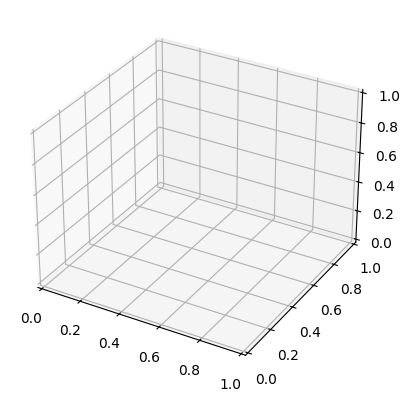

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for cluster in range(k):
    cluster_data = features_scaled[clusters == cluster]
    sample_data = cluster_data[np.random.choice(cluster_data.shape[0], 15, replace=False)]
    ax.scatter(sample_data[:, 0],  
               sample_data[:, 1],  
               sample_data[:, 2],
               label=f"Cluster {cluster+1}")

ax.set_xlabel("Voltage")
ax.set_ylabel("Global Reactive Power")
ax.set_zlabel("Global Intensity")
ax.tick_params(axis='x', labelbottom=False)
ax.tick_params(axis='y', labelleft=False)
ax.tick_params(axis='z', labelleft=False)

plt.title("Overall Consumption Clusters (K-Means, 3D)")
plt.legend()
plt.show()

## Implementazione parallela del K-MEANS

In [24]:
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Parallel K-means").getOrCreate()
spark

25/01/17 10:13:31 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [25]:
df = spark.read.csv("household_power_consumption.txt", sep=";", header=True, inferSchema=True)

In [26]:
cleaned_df = df.replace('?', None)
cleaned_df = cleaned_df.dropna()
selected_df = cleaned_df.select('Global_active_power', 'Voltage', 'Global_intensity')

In [27]:
from pyspark.ml.feature import Normalizer

rdd = selected_df.rdd.map(lambda row: Vectors.dense(row)) # vettori densi mi servono per i calcoli di ML
# nuovo DataFrame Spark con una colonna denominata "features"
data_df = rdd.map(lambda x: (Vectors.dense(x),)).toDF(["features"])

normalizer = Normalizer(inputCol="features", outputCol="normalized_features", p=2.0)
normalized_data_df = normalizer.transform(data_df)
normalized_rdd = normalized_data_df.select("normalized_features").rdd.map(lambda row: row[0])

In [28]:
# CARICO I DATI IN CACHE
normalized_rdd.cache()

PythonRDD[25] at RDD at PythonRDD.scala:53

In [29]:
num_partitions = normalized_rdd.getNumPartitions()
print(f"Numero di partizioni utilizzate: {num_partitions}")

Numero di partizioni utilizzate: 8


In [30]:
k = 3

In [31]:
import numpy as np

def generate_random_centroids(k, data):
    # seleziono casualmente k punti come centroidi
    centroids = data.takeSample(False, k, seed=42)
    return centroids

centroids = generate_random_centroids(k, normalized_rdd)
bcCentroids = spark.sparkContext.broadcast(centroids) # trasmetto centroidi a tutti i nodi di Spark

def compute_distance(point):
    # calcolo la distanza di un punto dal suo centroide
    centroids = bcCentroids.value
    distances = np.linalg.norm(point - np.array(centroids), axis=1) # calcolo le distanze euclidee tra un punto e un insieme di centroidi
    closest_centroid_idx = np.argmin(distances)
    return (closest_centroid_idx, (point, 1))

def update_step_sum(a, b):
    return (a[0] + b[0], a[1] + b[1])

def update_step_mean(cluster):
    return cluster[0] / cluster[1]

maxiter = 10

for itr in range(maxiter):
    closest = normalized_rdd.map(compute_distance) # assegno ciascun punto al centroide più vicino
    centroids = closest.reduceByKey(update_step_sum).mapValues(update_step_mean).collect() # aggiorno i centroidi
    centroids = [centroid for _, centroid in centroids] # estraggo i centroidi
    bcCentroids = spark.sparkContext.broadcast(centroids) # trasmetto i centroidi


In [32]:
for idx, centroid in enumerate(centroids):
    print(f"Centroide {idx + 1}: {centroid}")

Centroide 1: [0.015728125768121617,0.9974881672750378,0.06667383270491122]
Centroide 2: [0.0015281483587314339,0.9999701656414502,0.006736620302253507]
Centroide 3: [0.006848754818618243,0.9995396422172244,0.028628144457412307]


In [33]:
import numpy as np

# assegno punti ad ogni cluster
def assign_to_cluster(point, centroids):
    point_array = np.array(point)
    distances = np.linalg.norm(point_array - np.array(centroids), axis=1)
    return np.argmin(distances)

cluster_assignment = normalized_rdd.map(lambda point: assign_to_cluster(point, centroids)).collect()

In [34]:
from collections import Counter

cluster_counts = Counter(cluster_assignment)
for cluster_idx, count in cluster_counts.items():
    print(f"Cluster {cluster_idx} = {count} punti")

Cluster 0 = 163655 punti
Cluster 2 = 725906 punti
Cluster 1 = 1159719 punti


### Grafico KMEANS parallelo

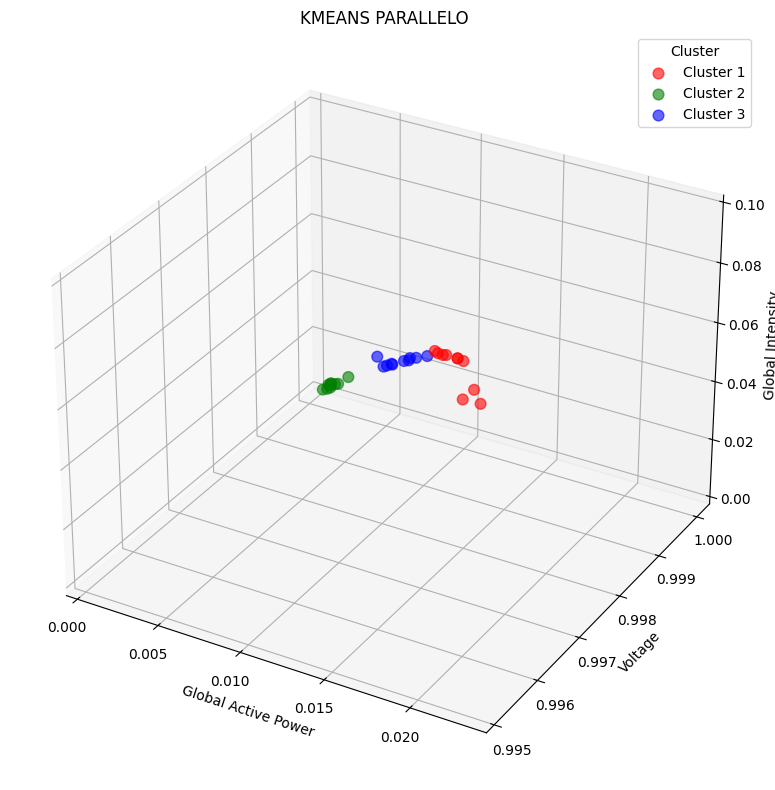

In [35]:
import matplotlib.pyplot as plt
import numpy as np

features_scaled = np.array(normalized_rdd.map(lambda vector: vector.toArray()).collect())
clusters = np.array(cluster_assignment)

k = 3
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(k):
    cluster_data = features_scaled[clusters == cluster]
    sample_data = cluster_data[np.random.choice(cluster_data.shape[0], min(10, cluster_data.shape[0]), replace=False)]
    ax.scatter(*sample_data.T[:3], label=f"Cluster {cluster + 1}", color=colors[cluster % len(colors)], alpha=0.6, s=60)

ax.set(xlabel="Global Active Power", ylabel="Voltage", zlabel="Global Intensity", title="KMEANS PARALLELO")
ax.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [36]:
spark.stop()

# ALGORITMO DBSCAN

## Implementazione DBSCAN da libreria

In [37]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('household_power_consumption.txt', delimiter=';', low_memory=False)
data = data.sample(frac=0.01, random_state=42) # 1% del dataset

data.replace('?', np.nan, inplace=True)
for col in data.columns[2:]:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.dropna(inplace=True)

features = data[['Global_active_power', 'Voltage', 'Global_intensity']].values
features_scaled = StandardScaler().fit_transform(features)

In [38]:
# SE MODIFICO FRAC > 3% DEI DATI COMMENTARE
# CODICE PER EVITARE CRASH DEL KERNEL

dbscan = DBSCAN(eps=0.3, min_samples=10)
clusters = dbscan.fit_predict(features_scaled)

In [39]:
import numpy as np

unique, counts = np.unique(clusters, return_counts=True)

print("Numero di punti per ciascun cluster:")
for cluster, count in zip(unique, counts):
    if cluster == -1:
        print(f"Outliers (-1): {count} punti")
    else:
        print(f"Cluster {cluster}: {count} punti")

Numero di punti per ciascun cluster:
Outliers (-1): 168 punti
Cluster 0: 20307 punti
Cluster 1: 11 punti


## Implementazione parallela DBSCAN

In [40]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("DBSCAN BigData") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.num.executors", "4") \
    .getOrCreate()
spark

In [41]:
import pandas as pd
import numpy as np

data = pd.read_csv('household_power_consumption.txt', delimiter=';', low_memory=False)
data = data.sample(frac=0.1, random_state=42) # prendo 10% del dataset per test

data.replace('?', np.nan, inplace=True)
for col in data.columns[2:]:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.dropna(inplace=True)

features = data[['Global_active_power', 'Voltage', 'Global_intensity']].values

In [42]:
from pyspark.ml.feature import StandardScaler, VectorAssembler

df = spark.createDataFrame(pd.DataFrame(features, columns=["Global_active_power", "Voltage", "Global_intensity"]))
df = df.repartition(8) # ottengo 8 partizioni

assembler = VectorAssembler(inputCols=["Global_active_power", "Voltage", "Global_intensity"], outputCol="features")
assembled_df = assembler.transform(df)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

### PCA con Spark

In [43]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_df)
pca_result_df = pca_model.transform(scaled_df)

pca_data = np.array(pca_result_df.select('pca_features').rdd.map(lambda x: x[0].toArray()).collect())

25/01/17 10:15:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/17 10:15:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/01/17 10:15:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [44]:
# funzione per calcolare distanza euclidea
def Distance(point1, point2):
    return np.linalg.norm(point1 - point2)

# funzione per trovare i vicini di un punto
def FindNeighbors(point, epsilon, data):
    neighbors = []
    for otherPoint in data:
        if Distance(point, otherPoint) <= epsilon: # se la distanza dal punto è <= di epsilon allora è un vicino
            neighbors.append(otherPoint)
    return neighbors

# funzione per espandere il cluster o generarne uno
def ExpandCluster(point, epsilon, minPoints, data, visited):
    cluster = [point]
    neighbors = FindNeighbors(point, epsilon, data)
    if len(neighbors) < minPoints: # se punto non ha abbastanza vicini non è core point
        visited.add(tuple(point))
        return None
    cluster.extend(neighbors)
    visited.update(tuple(p) for p in neighbors) # aggiorno i punti visitati
    return cluster

In [45]:
def ParallelDBSCAN(data, epsilon, minPoints):
    clusters = []
    visited = set()
    noise = set()
    
    rdd = spark.sparkContext.parallelize(data)
    
    def process_point(point):
        if tuple(point) not in visited: # se il punto non è stato visitato eseguo codice
            visited.add(tuple(point)) # segno come visitato
            cluster = ExpandCluster(point, epsilon, minPoints, data, visited)
            if cluster:
                return cluster
            else:
                noise.add(tuple(point)) # aggiungo al rumore
        return None
    
    # applico la funzione process_point a ogni punto
    results = rdd.map(process_point).filter(lambda x: x is not None).collect()
    
    for result in results:
        if result is not None:
            clusters.append(result)
    
    return clusters, noise

In [46]:
epsilon = 3.5
minPoints = 10
clusters, noise = ParallelDBSCAN(pca_data, epsilon, minPoints)

25/01/17 10:15:21 WARN TaskSetManager: Stage 22 contains a task of very large size (1035 KiB). The maximum recommended task size is 1000 KiB.


In [47]:
num_clusters = len(clusters)
print(f"Numero totale di cluster generati: {num_clusters}")

num_noise = len(noise)
print(f"Numero di punti considerati rumore: {num_noise}")

Numero totale di cluster generati: 49
Numero di punti considerati rumore: 0


### Grafico risultato implementazione parallela

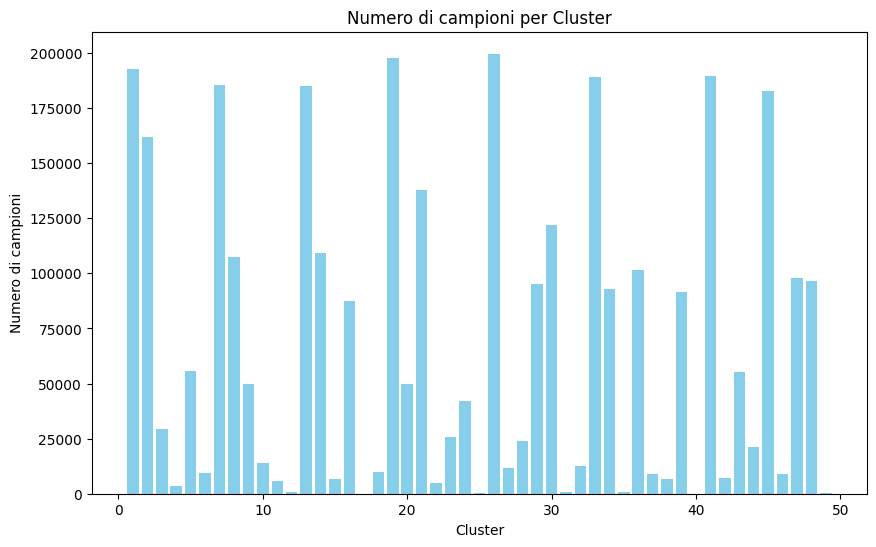

In [48]:
import matplotlib.pyplot as plt

cluster_sizes = [len(cluster) for cluster in clusters]

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(cluster_sizes) + 1), cluster_sizes, color='skyblue')

plt.xlabel("Cluster")
plt.ylabel("Numero di campioni")
plt.title("Numero di campioni per Cluster")

plt.show()

# IMPLEMENTAZIONE GMM

## Implementazione non parallela GMM standard

In [49]:
import pandas as pd

df_pd = pd.read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False)
df_pd = df_pd[["Global_active_power", "Global_reactive_power", "Voltage"]]
df_pd = df_pd.apply(pd.to_numeric, errors='coerce').dropna()

In [50]:
from sklearn.preprocessing import StandardScaler

data = df_pd.to_numpy()
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [51]:
n_components = 3
n_iter = 100
tol = 1e-4

In [52]:
import numpy as np

# Funzione di assegnazione delle probabilità di appartenenza (E-step)
def e_step(data, means, covariances, weights):
    responsibilities = np.zeros((data.shape[0], n_components))
    for k in range(n_components):
        diff = data - means[k]
        
        # calcolo l'inversa della matrice di covarianza del componente k
        inv_cov = np.linalg.inv(covariances[k])
        
        # calcolo determinante della matrice di covarianza (necessario per il calcolo della funzione gaussiana) 
        det_cov = np.linalg.det(covariances[k])
        
        # calcolo dell'esponente della funzione gaussiana per ogni punto
        # @ = matrice x matrice
        exponent = np.sum(diff @ inv_cov * diff, axis=1)
        
        # clip per evitare overflow / underflow
        exponent = np.clip(exponent, -500, 500)
        
        # calcolo della probabilità del componente k per ogni punto
        responsibilities[:, k] = weights[k] * np.exp(-0.5 * exponent) / (np.sqrt((2 * np.pi) ** data.shape[1] * det_cov))
    
    responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
    responsibilities /= responsibilities_sum  # normalizzazione
    return responsibilities

# Funzione di aggiornamento dei parametri (M-step)
def m_step(data, responsibilities):
    # somma delle responsabilità
    N_k = responsibilities.sum(axis=0)
    
    # aggiorno le medie
    means_new = np.dot(responsibilities.T, data) / N_k[:, None]
    
    # aggiorno le covarianze
    covariances_new = np.zeros((n_components, data.shape[1], data.shape[1]))
    
    # aggiorno la matrice di covarianza
    for k in range(n_components):
        diff = data - means_new[k]
        
        # differenza pesata con responsabilità del componente
        weighted_diff = responsibilities[:, k][:, None] * diff
        
        # calcolo la matrice di covarianza come media pesata dei prodotti esterni
        covariances_new[k] = np.dot(weighted_diff.T, diff) / N_k[k]
        
        # aggiungo regolarizzazione per evitare problemi numerici
        covariances_new[k] += np.eye(data.shape[1]) * 1e-3
    
    # aggiorno i pesi
    weights_new = N_k / data.shape[0]
    
    return means_new, covariances_new, weights_new


In [53]:
import numpy as np
from sklearn.cluster import KMeans

def compute_log_likelihood(data, means, covariances, weights):
    log_likelihood = 0
    for k in range(n_components):
        
        # differenza tra ogni punto e la media del componente k
        diff = data - means[k]
        
        # inversa della matrice di covarianza del componente k
        inv_cov = np.linalg.inv(covariances[k])
        
        # determinante della matrice di covarianza del componente k
        det_cov = np.linalg.det(covariances[k])
        
        # calcolo l'esponente della distribuzione gaussiana
        exponent = np.sum(diff @ inv_cov * diff, axis=1)
        
        # clip per evitare overflow / underflow
        exponent = np.clip(exponent, -500, 500)
        
        # calcolo la probabilità per il cluster k
        prob = weights[k] * np.exp(-0.5 * exponent) / (np.sqrt((2 * np.pi) ** data.shape[1] * det_cov))
        
        # aggiorno la log-verosimiglianza sommando la probabilità per il cluster k
        log_likelihood += prob 
    
    return np.sum(np.log(log_likelihood))  # somma logaritmica per tutti i punti

In [54]:
# inizializzazione K-means++
kmeans = KMeans(n_clusters=n_components, init='k-means++', random_state=42)
kmeans.fit(data)
means = kmeans.cluster_centers_

# inizializzo covarianze come matrici identità scalate
covariances = np.array([np.eye(data.shape[1]) * 0.1] * n_components)

# inizializzo i pesi dei cluster come uniformemente distribuiti
weights = np.ones(n_components) / n_components

# imposto il valore iniziale come negativo infinito
prev_log_likelihood = -np.inf

for iteration in range(n_iter):
    
    # E - STEP
    responsibilities = e_step(data, means, covariances, weights)
    
     # M - STEP
    means, covariances, weights = m_step(data, responsibilities)
    
    # LIKELIHOOD
    log_likelihood = compute_log_likelihood(data, means, covariances, weights)

    # CONTROLLO DELLA CONVERGENZA
    if np.abs(log_likelihood - prev_log_likelihood) < tol:
        print(f"Convergenza raggiunta all'iterazione {iteration + 1}")
        break

    # aggiorno log_likelihood precedente
    prev_log_likelihood = log_likelihood

In [55]:
# Assegnazione dei cluster
labels = np.argmax(responsibilities, axis=1)

# Calcolo delle proporzioni dei cluster
unique, counts = np.unique(labels, return_counts=True) # unique = elimino i duplicati e restituisco solo i valori distinti presenti nell'array
cluster_proportions = dict(zip(unique, counts)) # creo dizionario
print("Proporzioni dei cluster:", cluster_proportions)

Proporzioni dei cluster: {0: 711497, 1: 991267, 2: 346516}


### GRAFICO DISTRIBUZIONE CLUSTER GMM IMPLEMENTATO

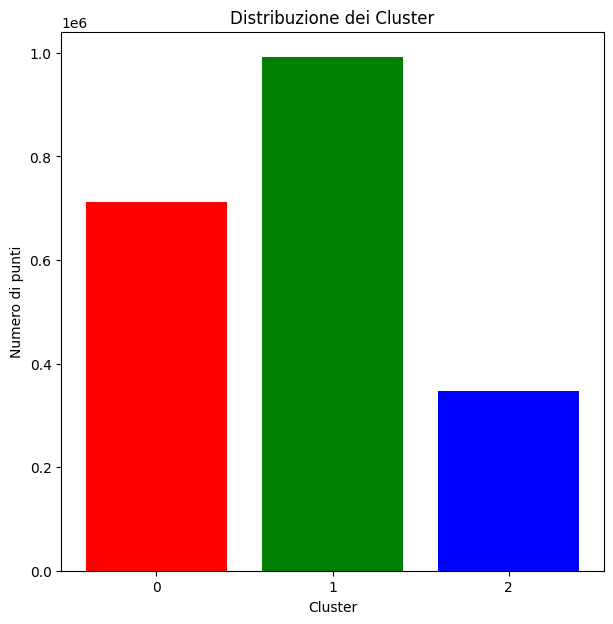

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.bar(cluster_proportions.keys(), cluster_proportions.values(), color=['r', 'g', 'b'])
plt.xlabel('Cluster')
plt.ylabel('Numero di punti')
plt.title('Distribuzione dei Cluster')
plt.xticks(list(cluster_proportions.keys()))
plt.show()

### GRAFICO DEI CENTROIDI GMM IMPLEMENTATO

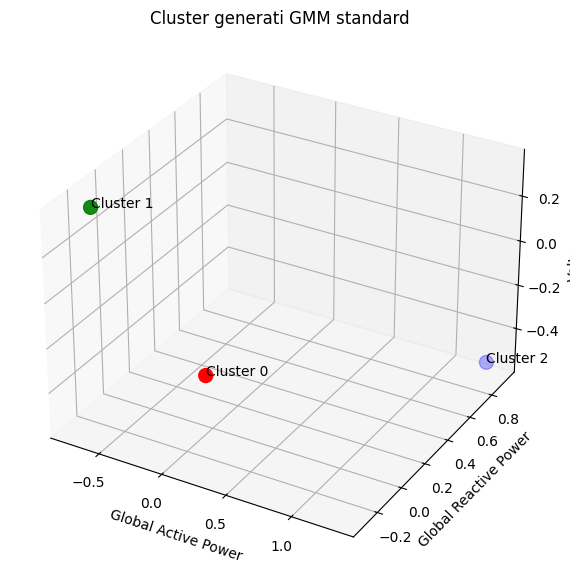

In [57]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

global_active_power = means[:, 0]
global_reactive_power = means[:, 1]
voltage = means[:, 2]

ax.scatter(global_active_power, global_reactive_power, voltage, c=['r', 'g', 'b'], s=100)
for i, label in enumerate([f'Cluster {i}' for i in range(len(means))]):
    ax.text(global_active_power[i], global_reactive_power[i], voltage[i], label, color='black')

ax.set_xlabel('Global Active Power')
ax.set_ylabel('Global Reactive Power')
ax.set_zlabel('Voltage')
plt.title('Cluster generati GMM standard')
plt.show()


### IMPLEMENTAZIONE GMM DA LIBRERIA

In [58]:
import pandas as pd

df_pd = pd.read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False)
df_pd = df_pd[["Global_active_power", "Global_reactive_power", "Voltage"]]
df_pd = df_pd.apply(pd.to_numeric, errors='coerce').dropna()

data = df_pd.to_numpy()

In [59]:
n_components = 3  
n_iter = 100  
tol = 1e-4

In [60]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

gmm = GaussianMixture(n_components=n_components, max_iter=n_iter, tol=tol, init_params='k-means++')
gmm.fit(data)

labels = gmm.predict(data)
responsibilities = gmm.predict_proba(data)

In [61]:
unique, counts = np.unique(labels, return_counts=True)
cluster_proportions = dict(zip(unique, counts))

### GRAFICO CENTROIDI GMM LIBRERIA

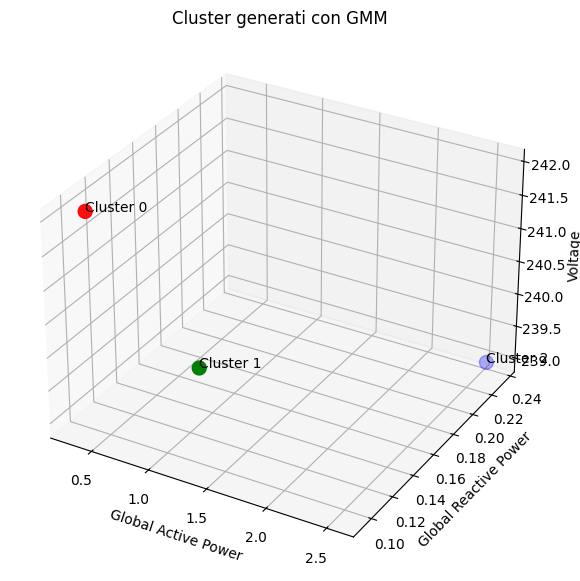

In [62]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

global_active_power = gmm.means_[:, 0]
global_reactive_power = gmm.means_[:, 1]
voltage = gmm.means_[:, 2]

ax.scatter(global_active_power, global_reactive_power, voltage, c=['r', 'g', 'b'], s=100)
for i, label in enumerate([f'Cluster {i}' for i in range(len(gmm.means_))]):
    ax.text(global_active_power[i], global_reactive_power[i], voltage[i], label, color='black')

ax.set_xlabel('Global Active Power')
ax.set_ylabel('Global Reactive Power')
ax.set_zlabel('Voltage')

plt.title('Cluster generati con GMM')
plt.show()

### DISTRIBUZIONE CLUSTER GMM LIBRERIA

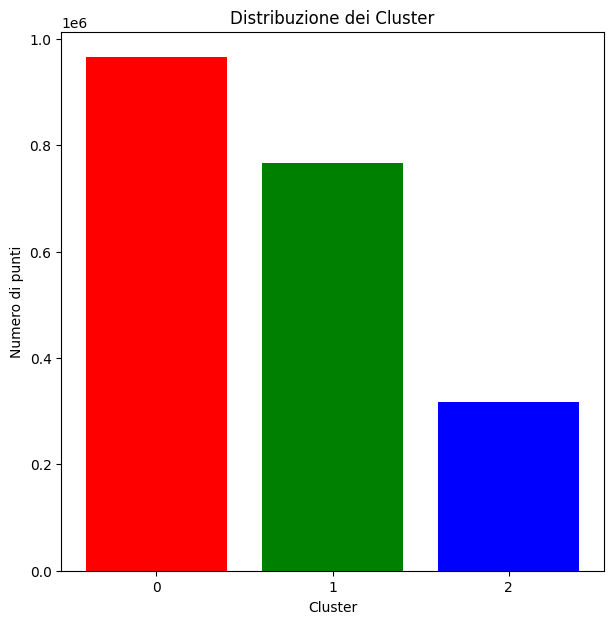

In [63]:
plt.figure(figsize=(7, 7))
plt.bar(cluster_proportions.keys(), cluster_proportions.values(), color=['r', 'g', 'b'])
plt.xlabel('Cluster')
plt.ylabel('Numero di punti')
plt.title('Distribuzione dei Cluster')
plt.xticks(list(cluster_proportions.keys()))
plt.show()

## IMPLEMENTAZIONE PARALLELA GMM DA LIBRERIA

In [64]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("GMM parallelo") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

spark

25/01/17 10:18:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [65]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler

df_spark = spark.read.csv('household_power_consumption.txt', sep=';', header=True, inferSchema=True)
df_spark = df_spark.select("Global_active_power", "Global_reactive_power", "Voltage")
df_spark = df_spark.withColumn("Global_active_power", col("Global_active_power").cast("float"))
df_spark = df_spark.withColumn("Global_reactive_power", col("Global_reactive_power").cast("float"))
df_spark = df_spark.withColumn("Voltage", col("Voltage").cast("float"))

df_spark = df_spark.dropna()

assembler = VectorAssembler(
    inputCols=["Global_active_power", "Global_reactive_power", "Voltage"],
    outputCol="features"
)
df_spark = assembler.transform(df_spark)

In [66]:
# CARICO IN CACHE IL DATASET
df_spark.cache()

DataFrame[Global_active_power: float, Global_reactive_power: float, Voltage: float, features: vector]

In [67]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.feature import PCA

# APPLICO PCA PER RIDURRE A 2 FEATURES
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_spark)
df_spark = pca_model.transform(df_spark)

In [68]:
gmm = GaussianMixture(k=3, maxIter=100, tol=1e-4, seed=42)
model = gmm.fit(df_spark)

In [69]:
print("Cluster weights: ", model.weights)
gaussians = model.gaussiansDF.collect()

print("Numero di partizioni:", df_spark.rdd.getNumPartitions())

Cluster weights:  [0.45496528769079697, 0.19661617418823996, 0.3484185381209631]
Numero di partizioni: 8


### GRAFICO DISTRIBUZIONE CLUSTER GMM PARALLELO

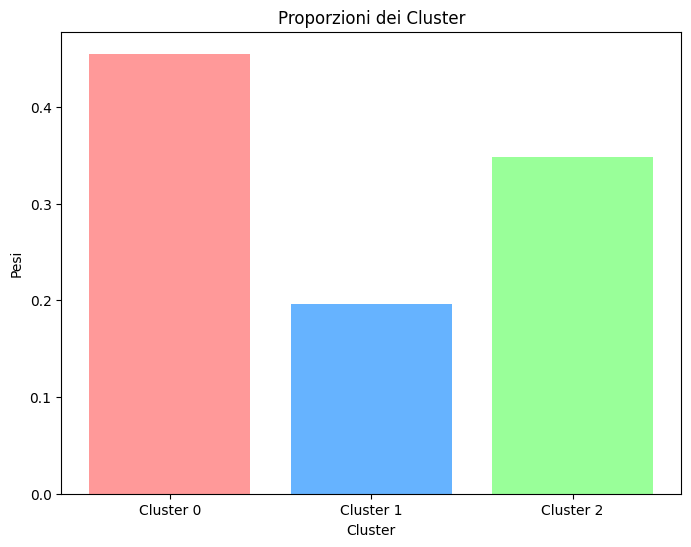

In [70]:
import matplotlib.pyplot as plt

weights = model.weights

plt.figure(figsize=(8, 6))
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']

plt.bar(labels, weights, color=['#ff9999','#66b3ff','#99ff99'])
plt.title("Proporzioni dei Cluster")
plt.xlabel("Cluster")
plt.ylabel("Pesi")

plt.show()

### GRAFICO CENTROIDI GMM PARALLELO

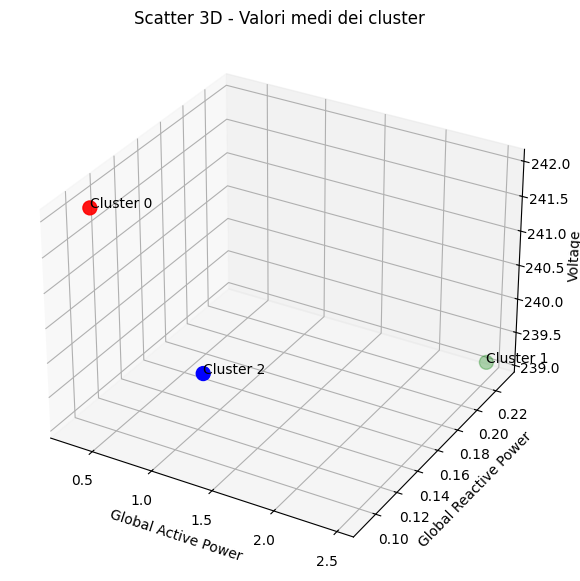

In [71]:
import matplotlib.pyplot as plt

gaussians = model.gaussiansDF.collect()

global_active_power = [gauss['mean'][0] for gauss in gaussians]
global_reactive_power = [gauss['mean'][1] for gauss in gaussians]
voltage = [gauss['mean'][2] for gauss in gaussians]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(global_active_power, global_reactive_power, voltage, c=['r', 'g', 'b'], s=100)
for i, label in enumerate(['Cluster 0', 'Cluster 1', 'Cluster 2']):
    ax.text(global_active_power[i], global_reactive_power[i], voltage[i], label, color='black')

ax.set_xlabel('Global Active Power')
ax.set_ylabel('Global Reactive Power')
ax.set_zlabel('Voltage')
plt.title('Scatter 3D - Valori medi dei cluster')
plt.show()

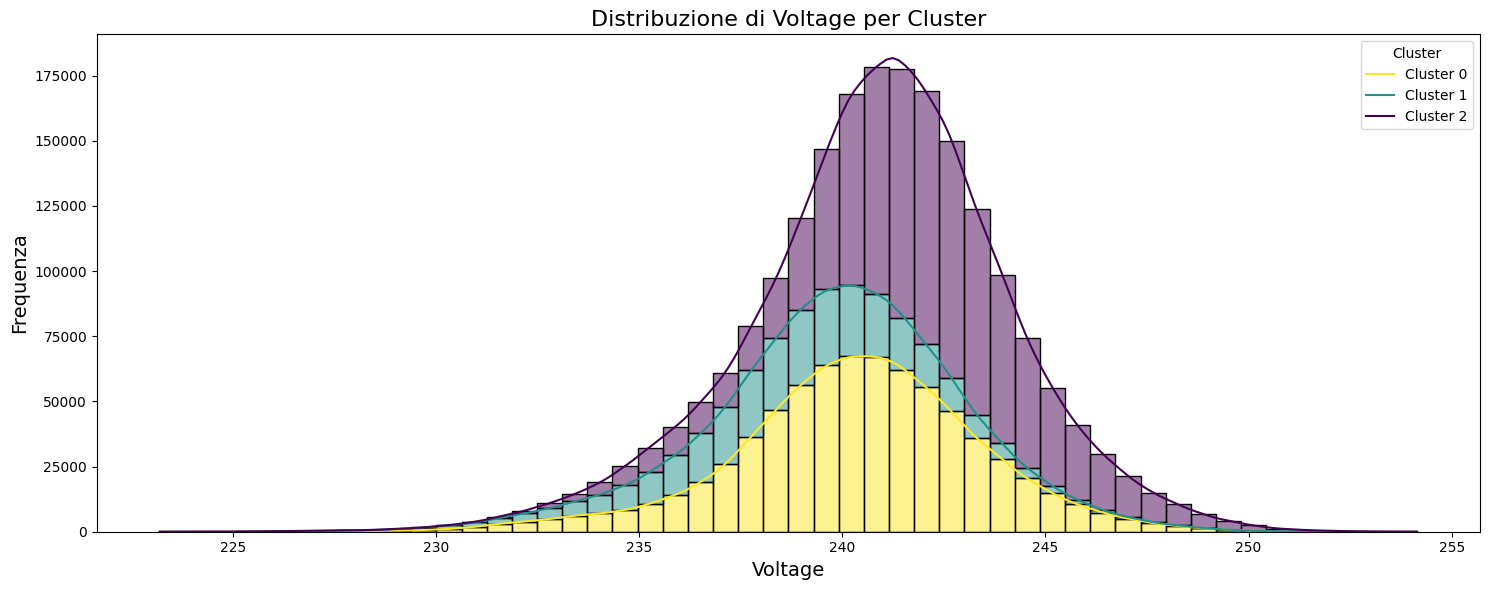

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

predictions = model.transform(df_spark)
df_spark_with_clusters = predictions.select("Global_active_power", "Global_reactive_power", "Voltage", "prediction").toPandas()

plt.figure(figsize=(15, 6))

sns.histplot(data=df_spark_with_clusters, x="Voltage", hue="prediction", kde=True, multiple="stack", palette="viridis", bins=50)

plt.title("Distribuzione di Voltage per Cluster", fontsize=16)
plt.xlabel("Voltage", fontsize=14)
plt.ylabel("Frequenza", fontsize=14)

plt.legend(title="Cluster", labels=["Cluster 0", "Cluster 1", "Cluster 2"], loc='upper right')

plt.tight_layout()
plt.show()

In [75]:
spark.stop()